In [1]:
using Gillespie
using Plots
using LinearAlgebra

In [12]:
# Model parameters.
ωA = 1.
ωB = 1.
ΩA = 0.
ΩB = 1.
γ1 = 0.1
γ2 = 0.01
g = 0.1

# Initial state.
ψ0_A = complex(float([1 ; 0]))
ψ0_B = complex(float([1 ; 0]))
ψ0 = kron(ψ0_A, ψ0_B)
ρ0 = ψ0 * ψ0'

# Simulation parameters.
t_final = 300.
dt = 0.01
number_trajectories = 10

# Operators.
σx = complex(float([0 1 ; 1 0]))
σy = complex(float([0 -1im ; 1im 0]))
σz = complex(float([1 0 ; 0 -1]))
ide = complex(float([1 0 ; 0 1]))
σp = (σx + 1im * σy)/2
σ = σp'
# Tensorized versions.
σ_A = kron(σ, ide)
σ_B = kron(ide, σ)
σx_A = kron(σx, ide)
σx_B = kron(ide, σx)
σz_A = kron(σz, ide)
σz_B = kron(ide, σz)

# Hamiltonian.
H = ωA * σz_A + ωB * σz_B + ΩA * σx_A + ΩB * σx_B + g * (σ_A * σ_B' + σ_A' * σ_B)

# Jump operator.
M1 = sqrt(γ1) * σ_B
M2 = sqrt(γ2) * σ_B'

# The jump operators have to be passed as lists.
M_l = [M1] # The emission channel is monitored.
S_l = [M2] # The absorption channel is not.

# Number operator.
num_op = [0 0 ; 0 1]
num_op_B = kron(ide, num_op);

In [13]:
results = Gillespie.compute_states_at_times_mixed(H, M_l, S_l, ρ0, t_final, dt, number_trajectories);
first_trajectory = results[1];

MethodError: MethodError: no method matching *(::Float64, ::Tuple{Transpose{ComplexF64, Matrix{ComplexF64}}, Matrix{Float64}})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/operators.jl:655
  *(::Union{Float16, Float32, Float64}, !Matched::BigFloat) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/mpfr.jl:406
  *(::Union{Real, Complex}, !Matched::Union{Adjoint{var"#s859", var"#s8591"}, Transpose{var"#s859", var"#s8591"}} where {var"#s859"<:Union{Real, Complex}, var"#s8591"<:(AbstractVector)}, !Matched::AbstractMatrix{<:Union{Real, Complex}}, !Matched::AbstractMatrix{<:Union{Real, Complex}}) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/stdlib/v1.7/LinearAlgebra/src/matmul.jl:1172
  ...

In [4]:
v_exp = []
for t in eachindex(first_trajectory)
    push!(v_exp, real(tr(num_op_B * first_trajectory[t])))
end

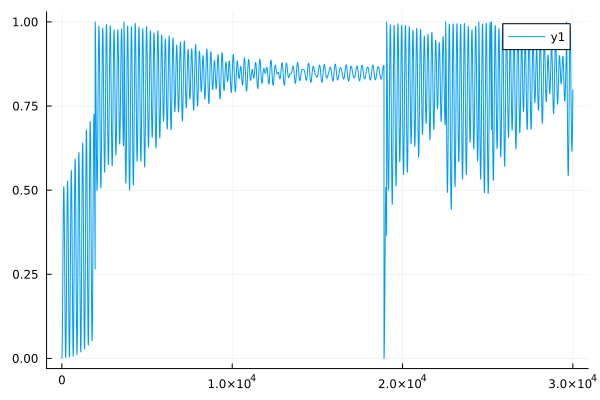

In [11]:
t_range = 1:dt:t_final
plot(v_exp)